In [1]:
#Imports
from matplotlib import pyplot as plt
import matplotlib
from sklearn import metrics
import pickle, typing
import numpy as np
import pandas as pd
import scikit_posthocs as sp
from statsmodels.stats.contingency_tables import cochrans_q

In [2]:
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'cmr10'
matplotlib.rcParams['font.size'] = 5

In [3]:
#Constants and global variables
DATA_DIR = 'D:/data'
K = 10
METHODS = ['none', 'cnn', 'border', 'smote', 'over', 'under', 'aug', 'aug_fine']
MODELS = ['bert-base-uncased',]
DATASETS = ['antisemitism_two', 'antisemitism_four', 'antisemitism_five', 
            'bbc', 'clothing_topic', 'clothing_rating', 'complaints', 
            'cyberbullying', 'disaster', 'disease', 
            'movies', 'website',
            ]
BINARY = ['antisemitism_two', 'cyberbullying', 'disaster',]
MULTI = ['antisemitism_four', 'antisemitism_five', 
         'bbc', 'clothing_topic', 'clothing_rating', 'complaints', 
         'disease', 'movies', 'website',]
MULTI_PLUS = ['clothing_topic', 'disease', 'movies', 'website',]
MULTI_MINUS = ['antisemitism_four', 'antisemitism_five', 
         'bbc', 'clothing_rating', 'complaints',]
REPLACEMENTS = {'Disaster': 'Dy', 'Bbc': 'BBC'}
METRICS = [metrics.f1_score,]

In [4]:
#Analysis helper functions
def open_analyze_file(method: str, model: str, dataset: str, metric: typing.Callable, micro: bool) -> float:
    '''Open and analyze a prediction and actual results file.'''
    with open(f'{DATA_DIR}/{method}/{model}/predictions-{dataset}', 'rb') as f:
        predictions = np.array(pickle.loads(f.read()).ravel())
    with open(f'{DATA_DIR}/{method}/{model}/test-output-{dataset}', 'rb') as f:
        actual = np.array(pickle.loads(f.read()))
        actual = actual[:-(actual.shape[0] % K)] if actual.shape[0] != predictions.shape[0] else actual
    
    return metric(actual, predictions, average=('micro' if micro else 'macro')) if metric == METRICS[0] else metric(actual, predictions)

def replace_name(name: str, shorten: bool) -> str:
    '''Shorten names.'''
    numbers = ['One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine', 'Ten']
    for number in numbers:
        name = name.replace(number, str(numbers.index(number)+1))
    for replacement in REPLACEMENTS:
        name = name.replace(replacement, REPLACEMENTS[replacement])
    if shorten:
        name = ''.join(word[:2] for word in name.split())
    return name

def get_all_preds(methods: list[str], model: str, dataset: str) -> tuple:
    '''Get all predictions from a list of methods.'''
    all_preds = []
    for method in methods:
        with open(f'{DATA_DIR}/{method}/{model}/predictions-{dataset}', 'rb') as f:
            predictions = np.array(pickle.loads(f.read()).ravel())
        with open(f'{DATA_DIR}/{method}/{model}/test-output-{dataset}', 'rb') as f:
            actual = np.array(pickle.loads(f.read()))
            actual = actual[:-(actual.shape[0] % K)] if actual.shape[0] != predictions.shape[0] else actual
        all_preds.append(np.array([prediction == actual[i] for i, prediction in enumerate(predictions)]))
    return all_preds

def visualize_dunn(preds: list[np.ndarray], datasets: list[str], model: str, label: str, lines: int, micro: bool, out: bool = False) -> list[np.ndarray]:
    '''Visualize the results of a post-hoc dunn analysis on a Cochran's Q test using MatPlotLib in a matrix.'''
    names = ['NO', 'CD', 'BS', 'SM', 'RO', 'RU', 'AU', 'AF']
    quotient = len(preds) // lines
    fig, ax = plt.subplots(lines, quotient,  figsize=(7.5, 7.5))
    copies = []
    if lines == 1:
        for i, dataset in enumerate(datasets):
            dunn_values = sp.posthoc_dunn(preds[i]).to_numpy()
            copies.append(dunn_values.copy())
            lower = np.tril(dunn_values, k=-1)
            for temp_ind, _ in enumerate(lower):
                for temp_j in range(temp_ind):
                    lower[temp_ind, temp_j] = 5.0
            dunn_values = np.ma.array(dunn_values, mask=lower)
            
            cmap = matplotlib.colormaps['viridis']
            cmap.set_bad('w')
            
            ax[i].matshow(dunn_values, cmap=cmap)
            
            #remove border
            ax[i].spines['top'].set_visible(False)
            ax[i].spines['right'].set_visible(False)
            ax[i].spines['bottom'].set_visible(False)
            ax[i].spines['left'].set_visible(False)
            
            #remove tick marks
            ax[i].tick_params(axis=u'both', which=u'both',length=0)
            
            ax[i].xaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
            rotation = 45 if out else 90
            #ax[i][j].set_xticklabels(labels=(names if i == quotient-1 else []), rotation=rotation)
            ax[i].set_xticklabels(labels=names, rotation=rotation)
            ax[i].yaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
            ax[i].tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
            ax[i].set_yticklabels(labels=(names if i == 0 else []))
            
            for (x, y), z in np.ndenumerate(dunn_values):
                if out and y >= x:
                    ax[i].text(y, x, ('{:0.1f}'.format(z)).replace('0.0', '0').replace('1.0', '1'), ha='center', va='center')
                elif y >= x:
                    ax[i].text(y, x, '{:0.1f}'.format(z), ha='center', va='center')
            
            ax[i].set_title(dataset.replace('_', ' ').title().replace('Bbc', 'BBC'))
    else:
        for index, dataset in enumerate(datasets):
            i, j = index // quotient, index % quotient
            dunn_values = sp.posthoc_dunn(preds[index]).to_numpy()
            copies.append(dunn_values.copy())
            lower = np.tril(dunn_values, k=-1)
            for temp_ind, _ in enumerate(lower):
                for temp_j in range(temp_ind):
                    lower[temp_ind, temp_j] = 5.0
            dunn_values = np.ma.array(dunn_values, mask=lower)
            
            cmap = matplotlib.colormaps['viridis']
            cmap.set_bad('w')
            
            ax[i][j].matshow(dunn_values, cmap=cmap)
            
            #remove border
            ax[i][j].spines['top'].set_visible(False)
            ax[i][j].spines['right'].set_visible(False)
            ax[i][j].spines['bottom'].set_visible(False)
            ax[i][j].spines['left'].set_visible(False)
            
            #remove tick marks
            ax[i][j].tick_params(axis=u'both', which=u'both',length=0)
            
            ax[i][j].xaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
            rotation = 45 if out else 90
            #ax[i][j].set_xticklabels(labels=(names if i == quotient-1 else []), rotation=rotation)
            ax[i][j].set_xticklabels(labels=(names if i == lines-1 else []), rotation=rotation)
            ax[i][j].tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
            ax[i][j].yaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
            ax[i][j].set_yticklabels(labels=(names if j == 0 else []))
            
            for (x, y), z in np.ndenumerate(dunn_values):
                if out and y >= x:
                    ax[i][j].text(y, x, ('{:0.1f}'.format(z)).replace('0.0', '0').replace('1.0', '1'), ha='center', va='center')
                elif y >= x:
                    ax[i][j].text(y, x, '{:0.1f}'.format(z), ha='center', va='center')
            
            ax[i][j].set_title(dataset.replace('_', ' ').title().replace('Bbc', 'BBC'))
    
    if out:
        #fig = ax.get_figure()
        fig.savefig(f'output/{model}-{micro}-{label}.pdf', bbox_inches='tight', pad_inches = 0)
            
    plt.pause(0.1)
    return copies

In [5]:
#High-level analysis functions
def analyze_method(method_name: str, model_name: str, metric: typing.Callable, micro: bool) -> np.ndarray:
    '''Analyze a method with a particular model and metric, giving scores on all datasets.'''
    return np.array([open_analyze_file(method_name, model_name, dataset, metric, micro) for dataset in DATASETS])

def analyze_methods(model_name: str, metric: typing.Callable, micro: bool) -> np.ndarray:
    '''Analyze all methods with a particular model and metric.'''
    return np.array([analyze_method(method, model_name, metric, micro) for method in METHODS])

def format_df(df: pd.DataFrame) -> pd.DataFrame:
    '''Format a dataframe for LaTeX conversion.'''
    array = df.to_numpy()
    percentages = [100 * (vector - array[0]) / array[0] for vector in array]
    perc_df = pd.DataFrame(columns=df.columns.values, index=df.index, data=percentages)
    for col in perc_df.columns.values:
        perc_df[col] = perc_df[col].apply(lambda x: f' ({int(x)}\\%)')
    perc_df = perc_df.astype(str)
    for col in df.columns.values:
        df[col] = df[col].apply(lambda x: float(f'{x:.3f}'))
        df[col].iloc[df[col].argmax()] = '\\bf{' + f'{df[col].max()}' + '}'
        df[col] = df[col].astype(str)
        df[col]= df[col].str.cat(perc_df[col], sep =" ")
    return df


bert-base-uncased


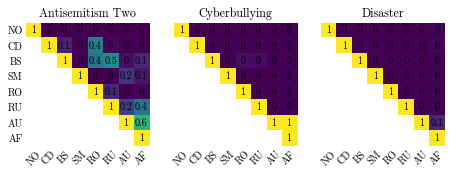

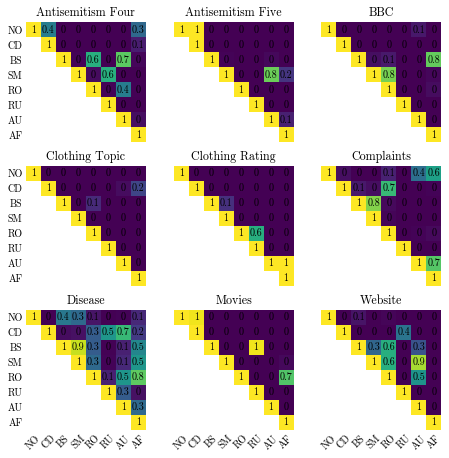

C:\Users\nicoc\AppData\Local\Temp\ipykernel_5548\3708626404.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].iloc[df[col].argmax()] = '\\bf{' + f'{df[col].max()}' + '}'
C:\Users\nicoc\AppData\Local\Temp\ipykernel_5548\5177864.py:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(format_df(latex_df).to_latex(escape=False))
C:\Users\nicoc\AppData\Local\Temp\ipykernel_5548\3708626404.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pand

<function f1_score at 0x00000184A782BA30>
              antisemitism_two antisemitism_four antisemitism_five       bbc  \
none                  0.419575          0.164634          0.167176   0.34875   
cnn                   0.502954          0.271322          0.167176  0.195347   
border                0.549169          0.265143          0.247981  0.732468   
smote                 0.611641          0.192767          0.309826  0.699643   
over                  0.532371           0.22563          0.253993  0.698544   
under                 0.555477          0.185132          0.141525  0.354503   
aug                   0.582327          0.252455           0.29141  0.585962   
aug_fine              0.578546          0.305267          0.312402  0.752434   
highest_score         0.611641          0.305267          0.312402  0.752434   
highest                  smote          aug_fine          aug_fine  aug_fine   

              clothing_topic clothing_rating complaints cyberbullying  \
none

In [6]:
micro = False
for model in MODELS:
    print(f'\n{model}')
    for metric in METRICS:                
        df = pd.DataFrame(data=analyze_methods(model, metric, micro), columns=DATASETS, index=METHODS)
        binary = [get_all_preds(METHODS, model, dataset) for dataset in BINARY]
        multi = [get_all_preds(METHODS, model, dataset) for dataset in MULTI]
                
        other_dunns = visualize_dunn(binary, BINARY, model, 'binary', 1, micro, True)
        other_dunns += visualize_dunn(multi, MULTI, model, 'multi', 3, micro, True)
        
        latex_df = df.copy()
        for col in BINARY + MULTI_PLUS:
            del latex_df[col]
        latex_df.columns = [replace_name(column.replace('_', ' ').title(), False).replace('Dy', 'Disaster') for column in latex_df.columns.values]
        latex_df.index = ['NO', 'CD', 'BS', 'SM', 'RO', 'RU', 'AU', 'AF']
        with open(f'output/LaTeX-multi-minus.tex', 'w') as f:
            f.write(format_df(latex_df).to_latex(escape=False))
            
        latex_df = df.copy()
        for col in BINARY + MULTI_MINUS:
            del latex_df[col]
        latex_df.columns = [replace_name(column.replace('_', ' ').title(), False).replace('Dy', 'Disaster') for column in latex_df.columns.values]
        latex_df.index = ['NO', 'CD', 'BS', 'SM', 'RO', 'RU', 'AU', 'AF']
        with open(f'output/LaTeX-multi-plus.tex', 'w') as f:
            f.write(format_df(latex_df).to_latex(escape=False))
        
        latex_df = df.copy()
        for col in MULTI:
            del latex_df[col]
        latex_df.columns = [replace_name(column.replace('_', ' ').title(), False).replace('Dy', 'Disaster') for column in latex_df.columns.values]
        latex_df.index = ['NO', 'CD', 'BS', 'SM', 'RO', 'RU', 'AU', 'AF']
        with open(f'output/LaTeX-binary.tex', 'w') as f:
            f.write(format_df(latex_df).to_latex(escape=False))
        
        df.loc['highest_score'] = df.apply(max, axis=0)
        df.loc['highest'] = df.apply('idxmax', axis=0)
        print(metric)
        print(df)
        print('\n\n')
        df.to_csv(f'output/{model}.csv')